In [44]:
import numpy as np
import asdf
import matplotlib.pyplot as plt
from astropy.modeling.models import Linear1D, Gaussian1D, Voigt1D
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling import fitting# import TRFLSQFitter
import astropy.units as u


In [45]:
with asdf.open("saved/m5_model.asdf") as ff:
    m5_model = ff['m5_model']

with asdf.open("saved/m1_model.asdf") as ff:
    m1_model = ff['m1_model']

m1_spec = np.load("saved/m1_spectra.npy")
m5_spec = np.load("saved/m5_spectra.npy")

badmom_m1 = np.load("saved/bad_m1.npy")
badmom_m5 = np.load("saved/bad_m5.npy")

xvals = np.load("saved/xvals.npy")

[Text(0.5, 1.0, 'Science Image (WL solution)'),
 Text(0.5, 1.0, 'Science Image (WL solution)')]

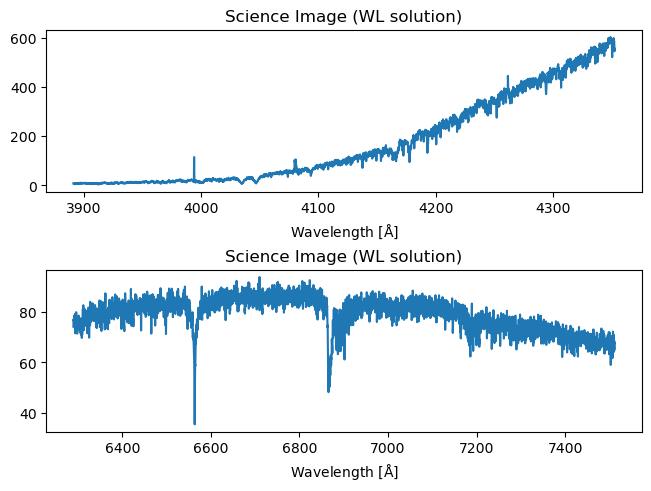

In [46]:
fig, [ax1, ax2] = plt.subplots(2, 1, layout='constrained')
ax1.plot(m1_model(xvals[~badmom_m1]), m1_spec)
ax2.plot(m5_model(xvals[~badmom_m5]), m5_spec)

[ax.set_xlabel(r"Wavelength [$\rm{\AA}$]") for ax in [ax1, ax2]]
[ax.set_title("Science Image (WL solution)") for ax in [ax1, ax2]]

## Toss out M1 images

(6500.0, 6650.0)

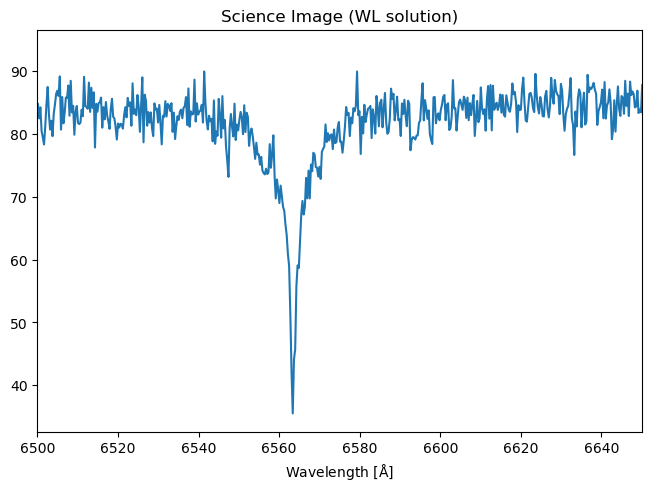

In [47]:
fig, ax = plt.subplots(1, 1, layout='constrained')
ax.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax.set_title("Science Image (WL solution)")
ax.set_xlim(6500, 6650)

In [68]:
m5_spec = m5_spec/np.median(m5_spec)
noise_estimate = np.std(m5_spec)


In [129]:
1/noise_estimate

lorentz_gam =  2 * u.AA
gauss_sig = 1 * u.AA
fwhm_l = 2 * lorentz_gam
fwhm_g = gauss_sig#2 * gauss_sig * (2*np.log(2))**(1/2)
amp_L = -0.5 * u.AA
guesses_voigt = [6563*u.AA, amp_L, fwhm_l, fwhm_g] # stats

In [130]:
wavelengths = m5_model(xvals[~badmom_m5]) * u.AA

selection = (wavelengths > 6500 * u.AA) & (wavelengths < 6650 * u.AA)
absorption_model_guess = Voigt1D(x_0=6563, amplitude_L=-0.5, fwhm_L=5, fwhm_G=1)#=-m5_spec[selection].min(),
                            #ean=6563,
                            #stddev=10)

fitter = fitting.LMLSQFitter()
fitted_gaussian = fitter(Voigt1D(*guesses_voigt), wavelengths[selection], m5_spec[selection],
                         weights=noise_estimate)
fitted_gaussian

UnitConversionError: 'Angstrom' (length) and '' (dimensionless) are not convertible

In [131]:
fin = Voigt1D(*guesses_voigt)

(6500.0, 6650.0)

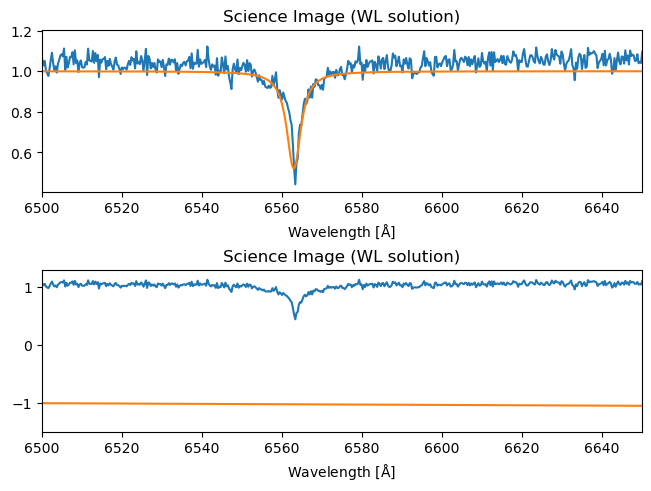

In [136]:
fig, [ax1, ax2] = plt.subplots(2, 1, layout='constrained')
ax1.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax1.plot(wavelengths, fin(wavelengths)+1*u.AA)
ax1.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax1.set_title("Science Image (WL solution)")
ax1.set_xlim(6500, 6650)

ax2.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax2.plot(wavelengths, -fitted_gaussian(wavelengths))
ax2.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax2.set_title("Science Image (WL solution)")
ax2.set_xlim(6500, 6650)


In [ ]:
fit_g = fitting.TRFLSQFitter()
fitted_absorption_model = fit_g(absorption_model_guess, x=wavelengths.value[selection], y=m5_spec[selection])

#fitted_absorption_model = lmfitter(
#    model=absorption_model_guess,  filter_non_finite=True)

    The maximum number of function evaluations is exceeded. [astropy.modeling.fitting]


(6500.0, 6650.0)

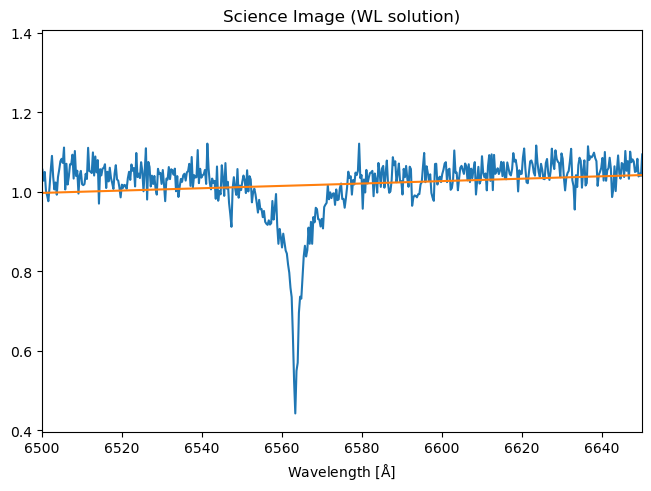

In [52]:
fig, ax = plt.subplots(1, 1, layout='constrained')
ax.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax.plot(wavelengths, fitted_absorption_model(wavelengths.value))
ax.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax.set_title("Science Image (WL solution)")
ax.set_xlim(6500, 6650)


In [ ]:
continuum_fit, absorption_fit = fitted_absorption_model

In [ ]:
fig, ax = plt.subplots(1, 1, layout='constrained')
ax.plot(m5_model(xvals[~badmom_m5]), m5_spec)
ax.plot(wavelengths,m5_spec-absorption_fit(wavelengths.value))
ax.set_xlabel(r"Wavelength [$\rm{\AA}$]")
ax.set_title("Science Image (WL solution)")
ax.set_xlim(6500, 6650)